# Challenge 02: Minimum Hamming Distance using a Quantum Algorithm

The Hamming distance between two binary strings (with the same number of bits) is defined as the number positions where the bits differ from each other. For example, the Hamming distance between these $6$-bit strings <span style="color:red">$0$</span>$01$<span style="color:red">$0$</span>$0$<span style="color:red">$1$</span> and <span style="color:red">$1$</span>$01$<span style="color:red">$1$</span>$0$<span style="color:red">$0$</span> is $3$.

A simple way to calculate the Hamming distance between two numbers is to perform a bitwise XOR between them, and count the number of ones in the resulting string:

$$ 001001 \oplus 101100 = 100101 \xrightarrow[]{\; \text{count ones} \;} 011 \text{ (3 in base-2)} $$

The purpose of this challenge is to develop a quantum algorithm that takes as an input an arbitrary number $m$ of $n$-bit strings, and outputs the two strings with the minimum Hamming distance between them with a resonably high probability. How high? the higher the better.

For instance, for the following input of four 4-bit strings: $[0000,1001,1100,1101]$ the algorithm should return strings $[1100,1101]$ since they only differ by one bit.

**Level 1:** Start by only considering the cases in which the answer is unique. In other words, assume that all inputs only have one pair of strings that gives the minimum Hamming distance. So inputs such as $[0000,0001,0010,0111]$ don't have to be considered because there are two solutions: $[0000,0001]$ and $[0000,0010]$.

**Level 2:** Now consider the case where more than one solution can exist and make sure the algorithm returns each of the possible solutions with equal probability. So, for the example above, the probability of measuring $[0000,0001]$ or $[0000,0010]$ should be close to $50\%$ (inputs with repeated strings should also be considered).

**Hint:** Consider looking into some of the "textbook" quantum algorithms (like Deutch-Jozsa (DJ) [1], Bernstein-Vazirani (BV) [2], Grover [3], etc.) to see if this problem can be solved with variations of these. Take for instance this pre-print [4], where a modified version of DJ was used to compute Hamming distances between two strings. Now, keep in mind that in that approach, Hamming weights were calculated using probability distributions (which require multiple runs of the algorithm), and not by amplifying states, as required by this challenge.


[1] Deutsch, David, and Richard Jozsa. "Rapid solution of problems by quantum computation." Proceedings of the Royal Society of London. Series A: Mathematical and Physical Sciences 439.1907 (1992): 553-558.

[2] Bernstein, Ethan, and Umesh Vazirani. "Quantum complexity theory." SIAM Journal on computing 26.5 (1997): 1411-1473.

[3] Grover, Lov K. , "A fast quantum mechanical algorithm for database search", Proceedings of the 28th Annual ACM Symposium on the Theory of Computing (1996), [arXiv:quant-ph/9605043](https://arxiv.org/abs/quant-ph/9605043)

[4] Bravo, José Manuel. "Calculating Hamming distance with the IBM Q Experience." Preprints (2018).

## Solution by Carlos Pegueros

This approach encodes the given entries (of $n$ bits each) in a $2n$ register as all the possible pair-combinations that can be formed between them.
For example, if there are 4 entries of 4 bits each, then $2n=8$ qubits are entangled from which only $4C2=6$ are 'valid' combinations. So, from all the $2^8$ states, only 6 will be marked (with an additional qubit) as a pair to be considered.
The Hamming distance is calculated following the approach from the problem statement (i.e. calculating the XOR and counting the amount of 1s) and the states which satisfy the following constraints are amplified:
* Hamming distance = 1 (minimum possible)
* The state represents a combination that was marked as valid

This introduces some issues that could be considered future work to generalize this solution:

* Is it possible to find the states with an unknown minimum Hamming distance (without assuming that it is 1)? 
* Grover's algorithm needs to be run for a specific amount of iterations to achieve the maximum amplification possible. The amount of iterations depends on the amount of qubits in the state to amplify $2^{n}$ (which we know) and on the amount of solutions to look for $k$. In the general case, we don't know $k$, so we would have to run the whole circuit several times (see [Wikipedia's article](https://en.wikipedia.org/wiki/Grover%27s_algorithm#Extension_to_space_with_multiple_targets)) until $k$ is found. In this solution, it is considered that $k$ is known in advance so the ideal amount of iterations are performed.

It is worth mentioning that in this approach, the amount of qubits required to encode the entries increases approximately by 4 each time 1 bit is added to $n$: 2 extra qubits are needed to encode the pairs, so we also need to add 2 extra ancilla qubits. This makes the circuit impractical as $n$ increases considering our current simulators can handle circuits with a limited amount of qubits (i.e. IBM's qasm_simulator supports up to 32 qubits), so a QRAM approach could be considered with the catch that the outputs would be QRAM addresses instead of the raw entries.

In [3]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from iqx import *

# Useful imports
from qiskit import ClassicalRegister, QuantumRegister

In [4]:
def find_pairs(entries, n):
    """
    Creates a circuit that, given a list of entries, marks the input qubits
    that form a valid pair-combination present in that list.
    For example, for entries=['01', '11'], the possible pair combinations are:
    
    ('01','11')
    
    So for the input qubits, only '0111' will be marked:
    
    '0000 0', '0001 0', ..., '0111 1', ..., '1111 0'
    
    Input is expected as:
    - n qubits as input1
    - n qubits as input2 (which will be combined with input1)
    - 1 qubit to be marked with 1 if input1+input2 is a valid combination
    - ancilla qubits that must be of length 2*n - 2

    Args
    --------------------
    entries: list of entires to combine. Each entry must be of length n
    n: length (in bits) of each entry
    """
    d0 = QuantumRegister(n,name="digits0")
    d1 = QuantumRegister(n,name="digits1")
    is_valid = QuantumRegister(1,name="is_valid")
    ancilla = QuantumRegister(2*n-2,name="anc")
    qc = QuantumCircuit(d0, d1, is_valid, ancilla, name="PairFinder")
    # Mark the pairs that are found in the possible pair-combinations of entries
    import itertools
    for i,j in itertools.combinations(entries, 2):
        # Init condition to identify i in d0 and j in d1
        if i.count('1') != n:
            qc.x([ d0[k] for k,digit in enumerate(i) if digit=='0' ])
        if j.count('1') != n:
            qc.x([ d1[k] for k,digit in enumerate(j) if digit=='0' ])
        # Mark the registers that form a pair present in the generated combinations
        qc.mct( d0[:] + d1[:], is_valid, ancilla, mode="basic" )
        # Uncompute condition
        if i.count('1') != n:
            qc.x([ d0[k] for k,digit in enumerate(i) if digit=='0' ])
        if j.count('1') != n:
            qc.x([ d1[k] for k,digit in enumerate(j) if digit=='0' ])
        qc.barrier()
    return qc

def diffuser(qbits, ancilla_amount=0):
    """
    Creates a circuit that performs a diffusion algorithm to the given qubits.
    The input is expected as: qbits qubits to diffuse, ancilla_amount qubits

    Args
    --------------------
    qbits: the amount of qbits to diffuse
    ancilla_amount: the amount of ancilla qubits to use by the MCT with mode=basic
    """
    qc = QuantumCircuit(qbits + ancilla_amount, name="diffuser")
    qlist = [i for i in range(0,qbits)]
    ancilla = [i for i in range(qbits, qbits+ancilla_amount)]
    # Apply transformation |s> -> |00..0> (H-gates)
    qc.h(qlist)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    qc.x(qlist)
    # Do multi-controlled-Z gate
    qc.h(qlist[-1])
    if ancilla_amount > 0:
        qc.mct(qlist[:-1], qlist[-1], ancilla, mode="basic")  # multi-controlled-toffoli
    else:
        qc.mct(qlist[:-1], qlist[-1])
    qc.h(qlist[-1])
    # Apply transformation |11..1> -> |00..0>
    qc.x(qlist)
    # Apply transformation |00..0> -> |s>
    qc.h(qlist)
    return qc

def one_counter(n):
    """
    Counts the amount of ones in an n qubit register.
    Qubits are expected as: n input, log2(n+1) output, log2(n+1)-2 ancilla
    The result is in the shape:
        count[4] ... count[0]
          LSB    ...   MSB
    i.e. 4 = '0010'
    
    Args
    --------------------
    n: size of the register whose 1s are going to be counted
    """
    import math
    c = math.ceil(math.log2(n+1))
    q = QuantumRegister(n,name="q")
    count = QuantumRegister(c,name="count")
    ancilla = QuantumRegister(c-2, name="ancilla")
    qc = QuantumCircuit(q,count,ancilla,name="OneCounter")
    # Count the amount of ones in 'q' bit by bit and store the result in 'count'
    for i in range(n):
        for j in range(len(count)):
            qc.mct( [q[i]] + count[j+1:], count[j], ancilla, mode="basic")
        qc.barrier()
    return qc

def hamming_calculator(n):
    """
    Calculates the Hamming distance between two n-size registers
    Qubits are expected as: n input1, n input2, log2(n+1) output/hamming distance, nh-2 ancilla
    
    Args
    --------------------
    n: size of the registers whose Hamming distance is going to be calculated
    """
    # Amount of qubits to store hamming distance
    import math
    nh = math.ceil(math.log2(n+1))
    # Create circuit
    in0 = QuantumRegister(n,name="in0")
    in1 = QuantumRegister(n,name="in1")
    distance = QuantumRegister(nh,name="distance")
    ancilla = QuantumRegister(nh-2, name="ancilla")
    qc = QuantumCircuit(in0,in1,distance,ancilla, name="CalcHamming")
    # Calculate the hamming distance between in0 and in1 and store in in1
    for i,j in zip(in0,in1):
        qc.cx(i,j)
    # Count the amount of ones in in1 and store the amount in distance as the result
    qc.append( one_counter(n), in1[:] + distance[:] + ancilla[:] )
    # Uncompute Hamming distance to restore in1
    for i,j in zip(in0,in1):
        qc.cx(i,j)
    # Return
    return qc

In [5]:
def calculate_ideal_amount_of_iterations(n, k=1):
    """
    Calculates the ideal amount of Grover's iterations required for n qubits
    (assuming k solutions). See:
    https://en.wikipedia.org/wiki/Grover%27s_algorithm#Extension_to_space_with_multiple_targets

    Args
    --------------------
    n: amount of qubits to be diffused
    k: amount of solutions
    """
    import math
    ideal_amount = (math.pi/4)*( math.sqrt(2**n/k) )
    # return closest integer
    return round(ideal_amount)

def challenge02(entries, iterations=None, solutions=1):
    # Get number of qubits required to represent the entries
    n = len(entries[0])
    # Get the number of qubits required to store the hamming distances
    import math
    nh = math.ceil(math.log2(n+1))
    # Calculate the ideal amount of iterations required for Grover's Algorithm if
    # no amount of iterations is passed.
    # TODO: how to extend this to the case where we don't know the amount of solutions
    # to look for? See Wikipedia for some suggestions
    if iterations is None:
        iterations = calculate_ideal_amount_of_iterations(2*n, solutions)
    print(f"Creating circuit with {iterations} iterations")
    # Create quantum circuit
    d0 = QuantumRegister(n,name="digits0")
    d1 = QuantumRegister(n,name="digits1")
    is_pair = QuantumRegister(1,name="is_pair")
    hamming = QuantumRegister(nh,name="hamming")
    oracle = QuantumRegister(1,name="oracle")
    ancilla = QuantumRegister(n+n-2,name="anc")
    bits = ClassicalRegister(2*n, name='bits')
    qc = QuantumCircuit(d0, d1, is_pair, hamming, oracle, ancilla, bits)
    # Init oracle
    qc.x(oracle)
    # Create all possible combinations of pairs of numbers
    qc.h( d0[:] + d1[:] )
    qc.barrier()

    # Amplify the pair(s) with HammingDistance=1 (which is the minimum possible)
    # TODO: how to extend this (or use a completely different approach) to consider the
    # case where the minimum distance is not known (i.e. it could be 2 instead of 1)?
    distance = bin(1)[2:].zfill(nh)
    # Perform Grover's algorithm
    for i in range(iterations):
        # Mark the pairs that are in the input
        qc.append( find_pairs(entries,n), d0[:] + d1[:] + is_pair[:] + ancilla[:] )
        # Calculate the hamming distances between each pair
        qc.append( hamming_calculator(n), d0[:] + d1[:] + hamming[:] + ancilla[:nh-2] )

        # Mark the states that are a valid pair AND have the minimum amount of ones
        qc.x([ hamming[k] for k,digit in enumerate(distance) if digit=='0' ])
        qc.h(oracle)
        qc.mct(is_pair[:] + hamming[:], oracle, ancilla, mode="basic" )
        qc.h(oracle)
        qc.x([ hamming[k] for k,digit in enumerate(distance) if digit=='0' ])

        # Uncompute distances
        qc.append( hamming_calculator(n).inverse(), d0[:] + d1[:] + hamming[:] + ancilla[:nh-2] )
        # Uncompute pairing mark
        qc.append( find_pairs(entries,n).inverse(), d0[:] + d1[:] + is_pair[:] + ancilla[:] )

        # diffuse
        qc.append( diffuser(2*n, 2*n-2), d0[:] + d1[:] + ancilla[:] )
        qc.barrier()

    # Measure
    qc.measure(d0[:] + d1[:], bits)
    return qc

The following is a helper function to plot histograms

In [6]:
def plot_top_n(counts, n):
    result = dict()
    temp = counts.copy()
    # Get top n counts
    for i in range(n):
        top = max(temp, key=temp.get)
        result[top] = temp.pop(top)
    # Save the rest
    result['rest'] = sum(temp.values())
    # Plot the new dictionary
    return plot_histogram(result, figsize=(20, 10))

## Test Case #1

Creating circuit with 9 iterations


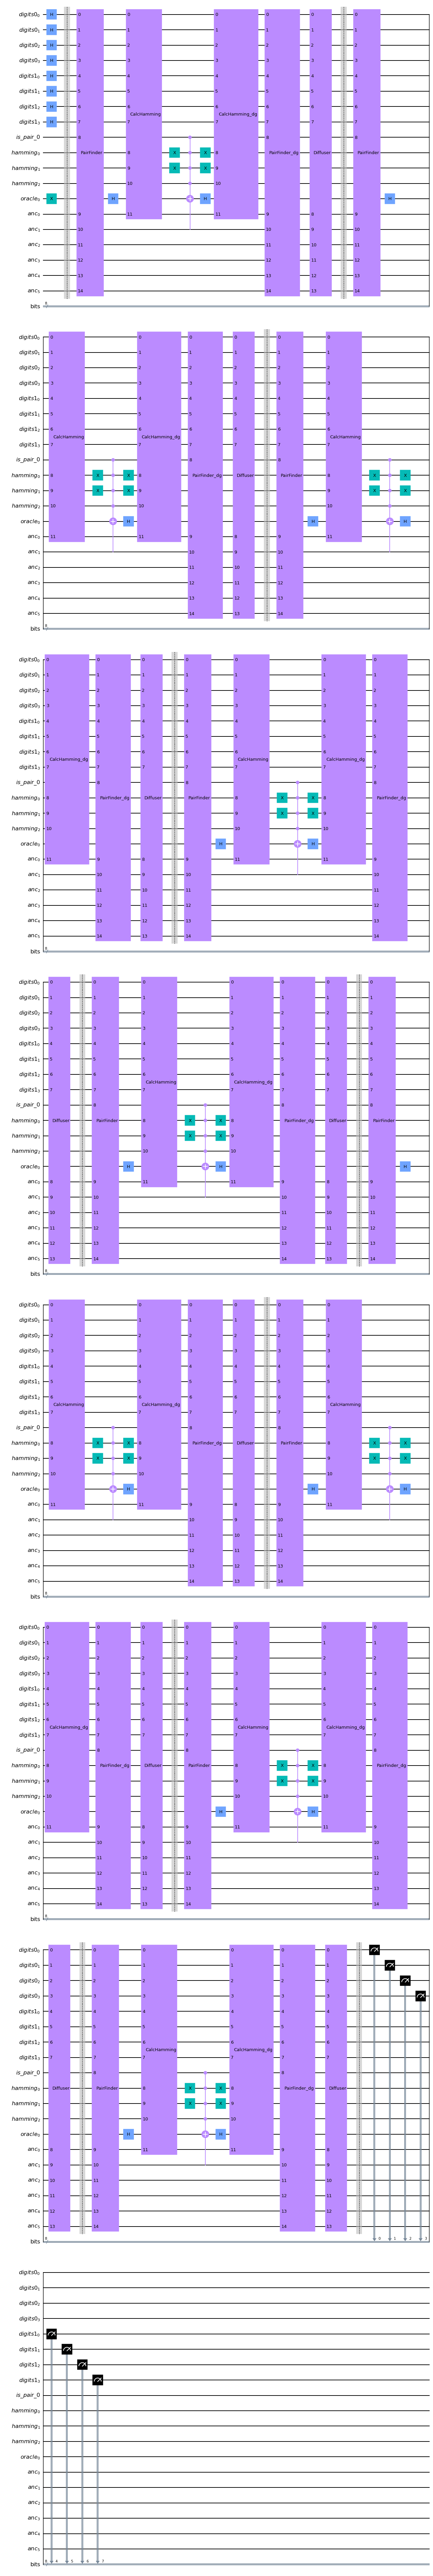

In [14]:
# Create circuit
entries = ['0000','1001','1100','1101']
circuit = challenge02(entries, solutions=2)
circuit.draw()

In [15]:
# Get backend and run job
backend = Aer.get_backend('qasm_simulator')
print("Executing job...")
job = execute(circuit, backend, shots=2000)
counts = job.result().get_counts()
print(counts)

Executing job...
{'00010011': 1, '00000011': 1, '00111010': 1, '00111111': 1, '01000111': 1, '01011010': 1, '01100000': 1, '01100101': 1, '01111011': 1, '10000000': 1, '10001011': 1, '10100110': 1, '10110000': 1, '10110011': 988, '10110110': 1, '10111001': 985, '10111101': 1, '10111110': 1, '11010010': 1, '11010100': 1, '11010110': 2, '11011010': 1, '11011101': 2, '11100111': 1, '11101110': 1, '11110000': 1, '11111000': 1}


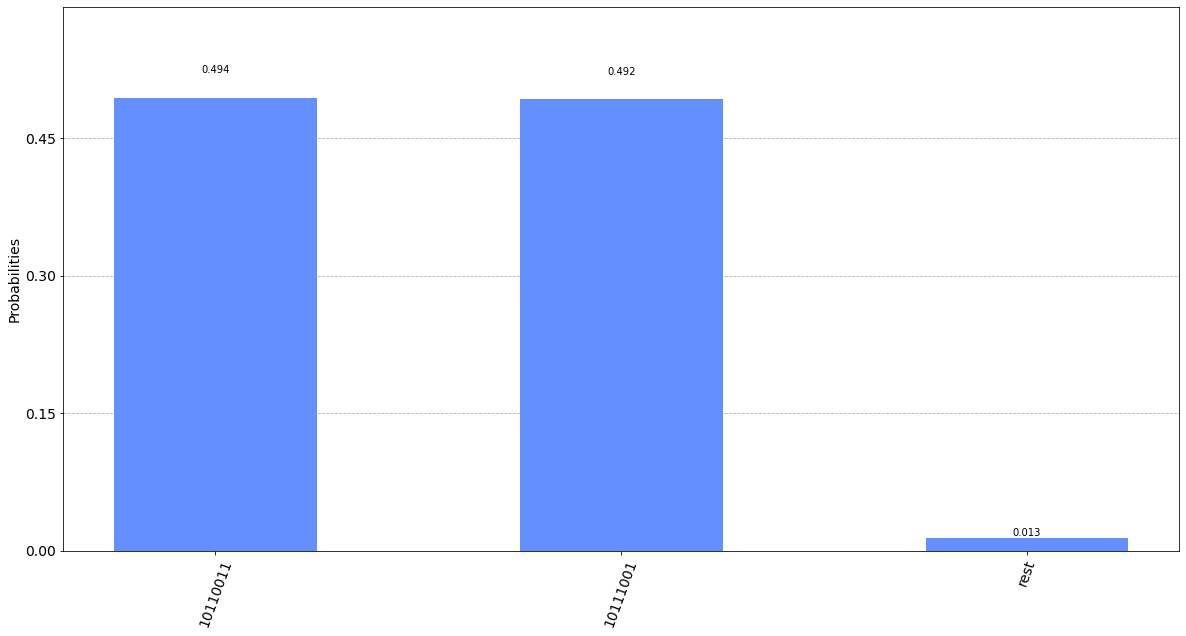

In [16]:
plot_top_n(counts,2)

# Test Case #2

Creating circuit with 18 iterations


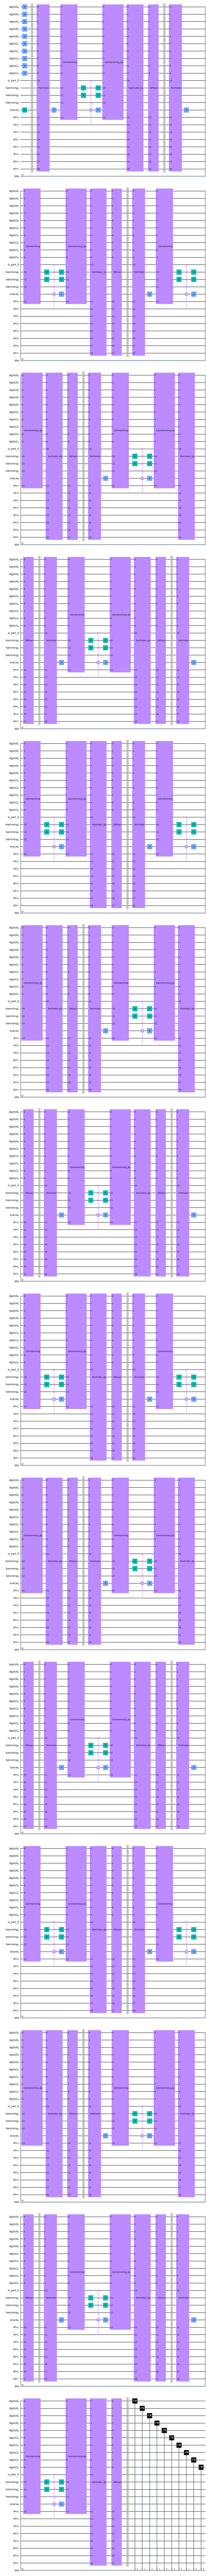

In [9]:
# Create circuit
entries = ['00000','00001','11000','11010']
circuit = challenge02(entries, solutions=2)
circuit.draw()

Executing job...


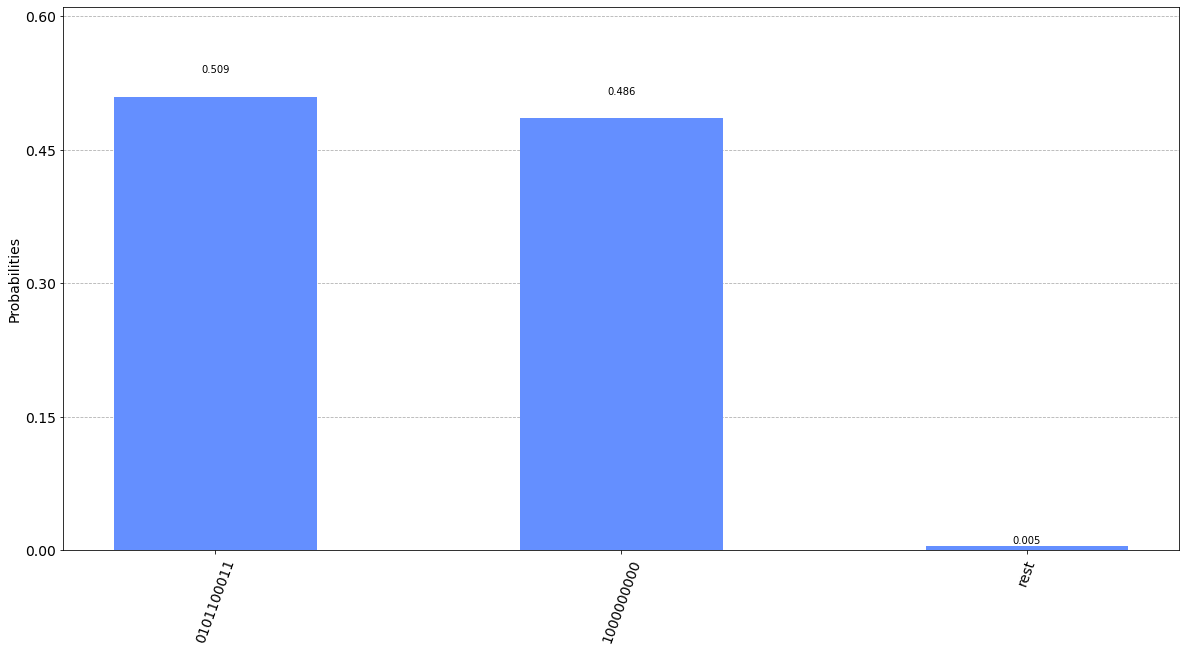

In [10]:
# Get backend and run job
backend = Aer.get_backend('qasm_simulator')
print("Executing job...")
job = execute(circuit, backend, shots=2000)
counts = job.result().get_counts()
plot_top_n(counts,2)